# Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import f1_score, accuracy_score
import joblib

# Read & view data

In [2]:
df = pd.read_csv('datasets/Food_Supply_kcal_Data.csv')

print(f"Number of rows: {df.shape[0]}")
print(f"Features: {list(df.columns)}")

df.head()

Number of rows: 170
Features: ['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats', 'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs', 'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Milk - Excluding Butter', 'Miscellaneous', 'Offals', 'Oilcrops', 'Pulses', 'Spices', 'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners', 'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']


,Country,Alcoholic Beverages,Animal Products,Animal fats,"Aquatic Products, Other",Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,...,Vegetable Oils,Vegetables,Obesity,Undernourished,Confirmed,Deaths,Recovered,Active,Population,Unit (all except Population)
0,Afghanistan,0.0000,4.7774,0.8504,0.0,37.1186,0.1501,0.0000,1.4757,1.2006,...,2.3012,0.7504,4.5,29.8,0.142134,0.006186,0.123374,0.012574,38928000.0,%
1,Albania,0.9120,16.0930,1.0591,0.0,16.2107,0.8091,0.1471,3.8982,3.8688,...,2.8244,2.7508,22.3,6.2,2.967301,0.050951,1.792636,1.123714,2838000.0,%
2,Algeria,0.0896,6.0326,0.1941,0.0,25.0112,0.4181,0.1195,3.1805,1.2543,...,5.7638,2.0457,26.6,3.9,0.244897,0.006558,0.167572,0.070767,44357000.0,%
3,Angola,1.9388,4.6927,0.2644,0.0,18.3521,0.0441,0.8372,2.3133,2.9302,...,4.2741,0.3525,6.8,25,0.061687,0.001461,0.056808,0.003419,32522000.0,%
4,Antigua and Barbuda,2.3041,15.3672,1.5429,0.0,13.7215,0.2057,1.7280,3.6824,7.0356,...,4.6904,1.2960,19.1,NaN,0.293878,0.007143,0.190816,0.095918,98000.0,%


# Data Cleaning

In [3]:
# First, let's check which columns have any NaN values
nan_cols = [i for i in df.columns if df[i].isnull().any()]
print(f"Columns with any NaN values: {nan_cols}")

# Now let's check how many NaN values each of those columns have
df[nan_cols].isna().sum()

Columns with any NaN values: ['Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active']


Obesity           3
Undernourished    7
Confirmed         6
Deaths            6
Recovered         6
Active            8
dtype: int64

In [4]:
# It is not that many rows with missing values, so let's drop them

df = df.dropna()

nan_cols = [i for i in df.columns if df[i].isnull().any()]
print(f"Columns with any NaN values: {nan_cols}")

# Now let's check how many NaN values each of those columns have
df[nan_cols].isna().sum()

Columns with any NaN values: []


Series([], dtype: float64)

In [5]:
# OPTIONAL: save the dataset

df.to_csv('datasets/kcal_proc.csv', index=False)

# Data Preprocessing

In [6]:
""" 
Now let's get rid of some features:
- Country: irrelevant for classification
- Animal Products: too broad

"""
print("Features before feature removal:")
print(list(df.columns))
print('-'*100)

df.drop(
	columns=['Country', 'Animal Products', 'Animal fats', 'Aquatic Products, Other', 
			'Miscellaneous', 'Obesity', 'Undernourished', 'Confirmed', 
			'Recovered', 'Active', 'Population', 'Unit (all except Population)', 'Vegetal Products'], 
	inplace=True)
print("Features after feature removal:")
print(list(df.columns))

Features before feature removal:
['Country', 'Alcoholic Beverages', 'Animal Products', 'Animal fats', 'Aquatic Products, Other', 'Cereals - Excluding Beer', 'Eggs', 'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Milk - Excluding Butter', 'Miscellaneous', 'Offals', 'Oilcrops', 'Pulses', 'Spices', 'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners', 'Treenuts', 'Vegetal Products', 'Vegetable Oils', 'Vegetables', 'Obesity', 'Undernourished', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Population', 'Unit (all except Population)']
----------------------------------------------------------------------------------------------------
Features after feature removal:
['Alcoholic Beverages', 'Cereals - Excluding Beer', 'Eggs', 'Fish, Seafood', 'Fruits - Excluding Wine', 'Meat', 'Milk - Excluding Butter', 'Offals', 'Oilcrops', 'Pulses', 'Spices', 'Starchy Roots', 'Stimulants', 'Sugar Crops', 'Sugar & Sweeteners', 'Treenuts', 'Vegetable Oils', 'Vegetables', 'Deaths']


Mean death percentage: 0.0399  
Median death percentage: 0.0126


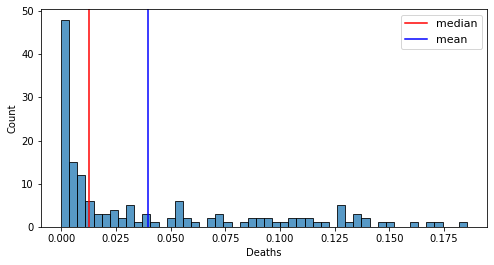

In [7]:
# we can see the distribution of deaths
# Perhaps, we can set the median of Deaths as the cut-off point, where
# anything below it is low mortality and anything above it is high mortality?
mean_deaths = df['Deaths'].mean()
median_deaths = df['Deaths'].median()
print(f"Mean death percentage: {mean_deaths:.4f}  \nMedian death percentage: {median_deaths:.4f}")

plt.figure(figsize=(8,4))
sns.histplot( data=df, x='Deaths', bins=50 )
plt.axvline( median_deaths, color='red', label='median' )
plt.axvline( mean_deaths, color='blue', label='mean' )
sns.set_context('notebook')
plt.legend();



In [8]:
# Because the distribution is non-normal, i would suggest using the median
df['Deaths_binary'] = df['Deaths'].apply( lambda x: 0 if x < median_deaths else 1 )

df.drop(
	columns=['Deaths'], 
	inplace=True)

df.head()

,Alcoholic Beverages,Cereals - Excluding Beer,Eggs,"Fish, Seafood",Fruits - Excluding Wine,Meat,Milk - Excluding Butter,Offals,Oilcrops,Pulses,Spices,Starchy Roots,Stimulants,Sugar Crops,Sugar & Sweeteners,Treenuts,Vegetable Oils,Vegetables,Deaths_binary
0,0.0000,37.1186,0.1501,0.0000,1.4757,1.2006,2.4512,0.1251,0.1751,0.5003,0.1001,0.3252,0.0750,0.0,2.2261,0.1251,2.3012,0.7504,0
1,0.9120,16.2107,0.8091,0.1471,3.8982,3.8688,9.9441,0.2648,1.0886,0.8091,0.0000,1.2651,0.2501,0.0,3.4422,0.3972,2.8244,2.7508,1
2,0.0896,25.0112,0.4181,0.1195,3.1805,1.2543,3.9869,0.0597,0.2688,1.0900,0.1195,1.9262,0.1493,0.0,3.9869,0.2240,5.7638,2.0457,0
3,1.9388,18.3521,0.0441,0.8372,2.3133,2.9302,0.5067,0.1102,1.0795,1.4981,0.0000,12.6239,0.0441,0.0,2.7539,0.0000,4.2741,0.3525,0
5,1.4354,16.7927,0.8643,0.2006,1.4663,9.4459,3.1641,0.2624,0.0309,0.1235,0.0309,1.4045,0.2315,0.0,7.0536,0.0463,5.5410,0.8643,1


# Models

## Train (default)

In [9]:
data = df.copy(deep=True)

features = data.drop(['Deaths_binary'], axis=1)
labels = data['Deaths_binary']

# Split the data into test-train-validation sets: 60-20-20%
## First split the data into two groups: one with train data, the other - with mixed test and validate
features_train, features_validation_test, labels_train, labels_validation_test = train_test_split(
	features, labels, test_size=0.4, random_state=100)
## Now, split the test-validate group into the separate test and validate groups
features_validation, features_test, labels_validation, labels_test = train_test_split(
	features_validation_test, labels_validation_test, test_size=0.5, random_state=100
)
print(f"For training, we will use {len(features_train)} features and {len(labels_train)} labels.")
print(f"For validation, we will use {len(features_validation)} features and {len(labels_validation)} labels.")
print(f"For testing, we will use {len(features_test)} features and {len(labels_test)} labels.")

For training, we will use 92 features and 92 labels.
For validation, we will use 31 features and 31 labels.
For testing, we will use 31 features and 31 labels.


In [10]:
# First, let's run the models with the default parameters

lr_model = LogisticRegression()
lr_model.fit(features_train, labels_train)

dt_model = DecisionTreeClassifier()
dt_model.fit(features_train, labels_train)

nb_model = GaussianNB()
nb_model.fit(features_train, labels_train)

svm_model = SVC()
svm_model.fit(features_train, labels_train)

rf_model = RandomForestClassifier()
rf_model.fit(features_train, labels_train)

gb_model = GradientBoostingClassifier()
gb_model.fit(features_train, labels_train)

ab_model = AdaBoostClassifier()
ab_model.fit(features_train, labels_train)

c:\Users\evgen\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


AdaBoostClassifier()

In [11]:
# Metric = accuracy

accuracy_scores = {}
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM', 'Random forest', 'Gradient Boosting', 'AdaBoost']

for i,j in zip( models, model_names ):
	accuracy_scores[j] = i.score(features_train, labels_train)

# Sort the dictionary based on value
accuracy_scores2 = dict(sorted(accuracy_scores.items(), key=lambda item: item[1], reverse=True))

print('TRAIN Accuracies (high -> low): ')
for i in accuracy_scores2:
	print(f" - {i}: {accuracy_scores2[i]:.2f}")

# The highest accuracy (81%) is that of gradient boosting


TRAIN Accuracies (high -> low): 
 - Decision Tree: 1.00
 - Random forest: 1.00
 - Gradient Boosting: 1.00
 - AdaBoost: 1.00
 - Logistic Regression: 0.89
 - Naive Bayes: 0.84
 - SVM: 0.76


In [12]:
# VAlidate

# Metric = accuracy

accuracy_scores = {}
models = [lr_model, dt_model, nb_model, svm_model, rf_model, gb_model, ab_model]
model_names = ['Logistic Regression', 'Decision Tree', 'Naive Bayes', 'SVM', 'Random forest', 'Gradient Boosting', 'AdaBoost']

for i,j in zip( models, model_names ):
	accuracy_scores[j] = i.score(features_validation, labels_validation)

# Sort the dictionary based on value
accuracy_scores2 = dict(sorted(accuracy_scores.items(), key=lambda item: item[1], reverse=True))

print('VALIDATE accuracies (high -> low): ')
for i in accuracy_scores2:
	print(f" - {i}: {accuracy_scores2[i]:.2f}")

# The highest accuracy (81%) is that of gradient boosting

VALIDATE accuracies (high -> low): 
 - Naive Bayes: 0.87
 - SVM: 0.87
 - Random forest: 0.87
 - Gradient Boosting: 0.87
 - AdaBoost: 0.87
 - Logistic Regression: 0.84
 - Decision Tree: 0.74


## Train (hyperparameters)

In [13]:
""" 
Let's choose the following:
- Naive Bayes: to test
- Gradient Boosting: to finetune
- Random forest: to finetune
""";

In [14]:
# Gradient boosting

grid_search_parameters = {
	'max_depth': [1,3,5,7,9], 
	'learning_rate': [0.01,0.1,1,10,100],
	'n_estimators': [5,50,250,500],
	# 'min_samples_split': np.linspace(0.1, 1.0, 5, endpoint=True),
	'min_samples_split': [0.1,0.4,0.7,1.0], 
	# 'min_samples_leaf': np.linspace(0.1, 0.5, 5, endpoint=True)
	'min_samples_leaf': [0.1,0.3,0.5]
}

gb_tune = GradientBoostingClassifier()
gb_tune2 = GridSearchCV(
	estimator=gb_tune, 
	param_grid=grid_search_parameters,
	refit=True)
gb_tune2.fit(features_train, labels_train)

print(gb_tune2.cv_results_.keys())
# iter = zip( gb_tune2.cv_results_['mean_train_score'], gb_tune2.cv_results_['mean_test_score']) 
# for i in iter:
# 	print(i)

gb_tune_best = gb_tune2.best_estimator_
print(f"The best estimator is {gb_tune_best} with parameters {gb_tune2.best_params_}")

print(f"Train accuracy: {gb_tune_best.score(features_train, labels_train)}")
print(f"Validation accuracy: {gb_tune_best.score(features_validation, labels_validation)}")



dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_learning_rate', 'param_max_depth', 'param_min_samples_leaf', 'param_min_samples_split', 'param_n_estimators', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])
The best estimator is GradientBoostingClassifier(learning_rate=1, max_depth=1, min_samples_leaf=0.1,
                           min_samples_split=0.1, n_estimators=50) with parameters {'learning_rate': 1, 'max_depth': 1, 'min_samples_leaf': 0.1, 'min_samples_split': 0.1, 'n_estimators': 50}
Train accuracy: 1.0
Validation accuracy: 0.7741935483870968


In [15]:
print(gb_tune_best.feature_importances_)

[1.59574862e-04 4.95962808e-03 1.57181583e-01 2.88556296e-01
 1.99388535e-02 5.26321647e-02 0.00000000e+00 0.00000000e+00
 1.97919168e-02 2.22821794e-02 4.35353971e-03 9.70882763e-04
 3.65657517e-02 0.00000000e+00 3.78049979e-01 3.76410521e-04
 1.20286417e-02 2.15259858e-03]


In [16]:
# Random forest
grid_search_parameters = {
	'max_depth': [1,5,10], 
	'min_samples_leaf': [1,5,10,15],
}

rf_tune = RandomForestClassifier()
rf_tune2 = GridSearchCV(
	estimator=rf_tune, 
	param_grid=grid_search_parameters,
	refit=True)
rf_tune2.fit(features_train, labels_train)

# print(rf_tune2.cv_results_.keys())
# iter = zip( rf_tune2.cv_results_['mean_train_score'], rf_tune2.cv_results_['mean_test_score']) 
# for i in iter:
# 	print(i)

rf_tune_best = rf_tune2.best_estimator_
print(f"The best estimator is {rf_tune_best} with parameters {rf_tune2.best_params_}")

print(f"Train accuracy: {rf_tune_best.score(features_train, labels_train)}")
print(f"Validation accuracy: {rf_tune_best.score(features_validation, labels_validation)}")


The best estimator is RandomForestClassifier(max_depth=10) with parameters {'max_depth': 10, 'min_samples_leaf': 1}
Train accuracy: 1.0
Validation accuracy: 0.8709677419354839


# Test

In [17]:
# I choose gradient boosting

In [18]:
predictions = gb_tune_best.predict( features_test )
print(f"Accuracy: {accuracy_score( labels_test, predictions ):.2f}")


Accuracy: 0.81


# Save the model

In [19]:
joblib.dump(gb_tune_best, "model.joblib")

loaded_model = joblib.load('model.joblib')
loaded_model

GradientBoostingClassifier(learning_rate=1, max_depth=1, min_samples_leaf=0.1,
                           min_samples_split=0.1, n_estimators=50)